<a href="https://colab.research.google.com/github/harshhrawte/LangGraph/blob/main/LangGraph_Lab_%E2%80%93_Customer_Support_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧪 LangGraph Lab – Customer Support Workflow

---
### 💾 Save a Copy Before You Start

Before making any changes, **save a copy** of this Colab notebook to your own Google Drive.  
This ensures your progress and edits are preserved.

#### 🪜 Steps:
1. Go to the top menu bar → **File**  
2. Click **Save a copy in Drive**  
3. Rename the notebook (e.g., `LangGraph_Customer_Support_Workflow.ipynb`)  
4. Work only on your saved copy.

> ✅ Tip: You can also use **Ctrl + Shift + S** (Windows) or **Cmd + Shift + S** (Mac) to quickly save a copy.

---
## 📌 Objective

In this lab, you’ll build a **multi-step AI workflow** using **LangGraph** and **Gemini** that:

- 🧭 Categorizes incoming customer queries into categories like **Technical**, **Billing**, or **General**  
- 🧠 Analyzes the sentiment of the query (**Positive**, **Neutral**, **Negative**)  
- 🔀 Routes the query to the correct handler based on the sentiment and category  
- 🆘 Escalates the query to a human agent if sentiment is **negative**

---

## 🛠️ What You'll Learn

- 🧩 How to define and use **LangGraph workflows**  
- 💬 How to use **prompt chains** with Gemini models  
- 🛤️ How to implement **conditional routing** in conversational workflows  
- 📊 How to **visualize LangGraph flows** for better understanding of the process


In [1]:
# Install necessary packages
!pip install -q langgraph langchain-core python-dotenv langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.9.0 which is incompatible.


## Import necessary libraries


In [2]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os

## 🔐 How to Add Your API Key Securely in Google Colab (Recommended)

Instead of hardcoding your API key in the notebook (❌ not secure), it’s best to use **Colab’s Secret Manager**.  
Follow these steps carefully 👇

---

### 🪜 Step 1: Open the “Secrets” Panel
1. In Google Colab, go to the **left sidebar**.  
2. Click on the **🔑 “Secrets” (key icon)** tab.  
   - If you don’t see it, click on the **“⋮” (three dots)** and choose “Secrets”.

---

### 🧾 Step 2: Add a New Secret
1. Click **“+ Add new secret”**.  
2. In the **Name** field, enter:
3. In the **Value** field, paste your **Gemini API key**.  
4. Click **“Save”** ✅

> 💡 Tip: This way, the key is stored securely and **won’t appear in your code**.

---

### 🧰 Step 3: Access the Secret in Your Notebook
Once you’ve saved the secret, you can access it like this:




In [3]:
from google.colab import userdata
import os

# Make sure you have added the secret in Colab -> Tools -> Secrets
api_key = userdata.get("GOOGLE_API_KEY")

if api_key:
    os.environ["GOOGLE_API_KEY"] = api_key
    print("✅ API key loaded securely!")
else:
    print("❌ API key not found! Please set it in Colab Secrets.")


✅ API key loaded securely!


## 🧠 `State` Class Overview


### 🔍 Description

`State` defines a structured dictionary for managing data flow in a workflow or graph (e.g., LangGraph).

| Key        | Type | Description |
|-------------|------|-------------|
| `query`     | `str` | User’s input question or text. |
| `category`  | `str` | Classified topic or label of the query. |
| `sentiment` | `str` | Detected emotional tone (e.g., Positive, Negative, Neutral). |
| `response`  | `str` | AI-generated or processed answer. |


In [4]:
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

### 🧩 Function: `categorize(state: State) -> State`

This function classifies a customer’s query into one of three categories — **Technical**, **Billing**, or **General** — using Google’s **Gemini** model.

In [5]:
def categorize(state: State) -> State:
    """Categorize the customer query into Technical, Billing, or General."""

    # 1️⃣ Create a prompt template for categorization
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}"
    )

    # 2️⃣ Connect the prompt to Gemini model
    chain = prompt | ChatGoogleGenerativeAI(model="gemini-2.0-flash")

    # 3️⃣ Pass the user query and get category result
    category = chain.invoke({"query": state["query"]}).content

    # 4️⃣ Return the updated state with category
    return {"category": category}

### 💬 Function: `analyze_sentiment(state: State) -> State`

This function determines the **sentiment** of a customer’s query — whether it’s **Positive**, **Neutral**, or **Negative** — using the **Gemini 2.0 Flash** model.

#### 🧠 Explanation

| Step | Description |
|------|--------------|
| 1️⃣ | A **prompt template** is created asking Gemini to analyze sentiment. |
| 2️⃣ | The prompt is **linked** with the Gemini model using a chain. |
| 3️⃣ | The model is **invoked** with the query and returns the sentiment result. |
| 4️⃣ | The function returns a dictionary containing the `sentiment` value. |

#### ✅ Example
```python
state = {"query": "I'm very unhappy with your customer service."}
analyze_sentiment(state)
# Output: {'sentiment': 'Negative'}


In [6]:
def analyze_sentiment(state: State) -> State:
    """Analyze the sentiment of the customer query as Positive, Neutral, or Negative."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )

    chain = prompt | ChatGoogleGenerativeAI(model="gemini-2.0-flash")
    sentiment = chain.invoke({"query": state["query"]}).content
    return {"sentiment": sentiment}

### 🛠️ Function: `handle_technical(state: State) -> State`

This function generates a **technical support response** for customer queries using the **Gemini 2.0 Flash** model.

#### 🧠 Explanation

| Step | Description |
|------|--------------|
| 1️⃣ | A **prompt template** instructs Gemini to provide a technical support response. |
| 2️⃣ | The prompt is **linked** to the Gemini model via a chain (`prompt | ChatGoogleGenerativeAI`). |
| 3️⃣ | The model is **invoked** with the query and returns a suitable response. |
| 4️⃣ | The function returns a dictionary with the generated `response`. |

#### ✅ Example
```python
state = {"query": "My app keeps crashing after the latest update."}
handle_technical(state)
# Output: {'response': 'Please try reinstalling the app or clearing its cache to fix the issue.'}


In [7]:
def handle_technical(state: State) -> State:
    """Provide a technical support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query: {query}"
    )

    chain = prompt | ChatGoogleGenerativeAI(model="gemini-2.0-flash")
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

### 💰 Function: `handle_billing(state: State) -> State`

This function generates a **billing-related support response** using the **Gemini 2.0 Flash** model.

#### 🧠 Explanation

| Step | Description |
|------|--------------|
| 1️⃣ | A **prompt template** instructs Gemini to craft a billing-related response. |
| 2️⃣ | The prompt is **chained** with the Gemini model (`prompt | ChatGoogleGenerativeAI`). |
| 3️⃣ | The model is **invoked** with the user's query to generate the billing response. |
| 4️⃣ | The output is returned as a dictionary containing the key `response`. |

#### ✅ Example
```python
state = {"query": "I need a copy of my last payment receipt."}
handle_billing(state)
# Output: {'response': 'You can find your payment receipt under Billing > Transaction History in your account settings.'}


In [8]:
def handle_billing(state: State) -> State:
    """Provide a billing support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query: {query}"
    )

    chain = prompt | ChatGoogleGenerativeAI(model="gemini-2.0-flash")
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

### 🌐 Function: `handle_general(state: State) -> State`

This function generates a **general support response** for queries that do not fall under Technical or Billing, using **Gemini 2.0 Flash**.

#### 🧠 Explanation

| Step | Description |
|------|--------------|
| 1️⃣ | Create a **prompt template** instructing Gemini to provide a general support response. |
| 2️⃣ | Chain the prompt with the Gemini model (`prompt | ChatGoogleGenerativeAI`). |
| 3️⃣ | Invoke the model with the query to get a response. |
| 4️⃣ | Return the response in a dictionary with the key `response`. |

#### ✅ Example
```python
state = {"query": "What are your customer service hours?"}
handle_general(state)
# Output: {'response': 'Our customer service is available Monday to Friday, 9 AM to 6 PM.'}


In [10]:
def handle_general(state: State) -> State:
    """Provide a general support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )

    chain = prompt | ChatGoogleGenerativeAI(model="gemini-2.0-flash")
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

### 🚨 Function: `escalate(state: State) -> State`

This function handles queries with **negative sentiment** by escalating them to a **human agent** instead of providing an AI-generated response.

#### 🧠 Explanation

| Step | Description |
|------|--------------|
| 1️⃣ | No AI processing is needed; the function directly returns a predefined escalation message. |
| 2️⃣ | The returned dictionary contains the key `response` with a message indicating escalation. |

#### ✅ Example
```python
state = {"query": "I'm very unhappy with your service!"}
escalate(state)
# Output: {'response': 'This query has been escalated to a human agent due to its negative sentiment.'}


In [11]:
def escalate(state: State) -> State:
    """Escalate the query to a human agent due to negative sentiment."""
    return {"response": "This query has been escalated to a human agent due to its negative sentiment."}

### 🔀 Function: `route_query(state: State) -> str`

This function **decides the next step** in the workflow based on the query’s **sentiment** and **category**.

#### 🧠 Explanation

| Step | Description |
|------|-------------|
| 1️⃣ | If the sentiment is `"Negative"`, route the query to **escalation** for a human agent. |
| 2️⃣ | If the category is `"Technical"`, route to `handle_technical`. |
| 3️⃣ | If the category is `"Billing"`, route to `handle_billing`. |
| 4️⃣ | Otherwise, route to `handle_general`. |

#### ✅ Example
```python
state = {"category": "Technical", "sentiment": "Neutral"}
route_query(state)
# Output: 'handle_technical'

state = {"category": "General", "sentiment": "Negative"}
route_query(state)
# Output: 'escalate'


In [12]:
def route_query(state: State) -> str:
    """Route the query based on its sentiment and category."""
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    else:
        return "handle_general"

### 🏗️ Building the LangGraph Workflow

This section creates the **customer support workflow graph** using `StateGraph`. Each node represents a step in processing the query.

---

### 🧩 Step 1: Create the Graph

```python
workflow = StateGraph(State)
```
Initializes a state-based graph using the State dictionary structure.

This defines the data model that will flow through the workflow.

---

### 🧩 Step 2: Add Nodes

```python
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)
```
Each node represents a specific function in the workflow.

Nodes define tasks or actions the workflow can perform, such as categorizing queries or generating responses.

---
### 🧩 Step 3: Add Edges

```python
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)
```
Edges define the flow between nodes in the workflow.

add_conditional_edges allows dynamic routing based on sentiment and category.

END marks the completion of a workflow path.

---
### 🧩 Step 4: Set Entry Point

```python
workflow.set_entry_point("categorize")
Defines the starting node of the workflow.
```

All queries will begin with the categorization step before moving through the rest of the workflow.

---
### 🧩 Step 5: Compile the Graph

```python
app = workflow.compile()
```

Compiles the workflow into an executable LangGraph application.

After compilation, the workflow can be invoked with user queries to process them through all defined steps.

In [13]:
# Create the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

# Add edges
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

# Set entry point
workflow.set_entry_point("categorize")

# Compile the graph
app = workflow.compile()

## Visualize the Graph

This cell generates and displays a visual representation of our LangGraph workflow.

- Uses Mermaid diagrams to render the workflow visually.

- draw_mermaid_png generates a graph image showing all nodes and edges.

- Helps understand the flow of customer queries through the workflow.

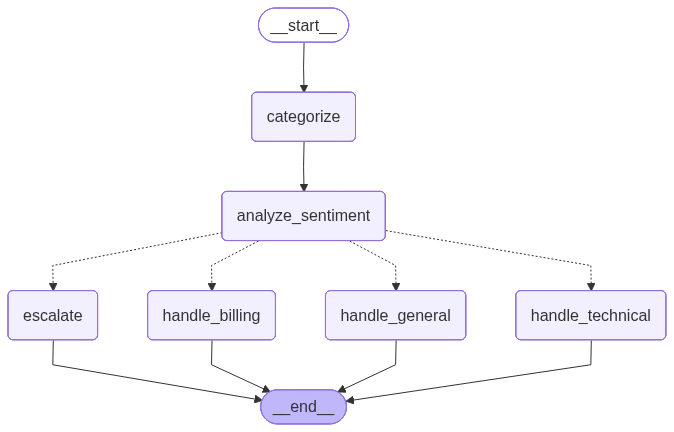

In [14]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### 🚀 Function: `run_customer_support(query: str) -> Dict[str, str]`

This function **runs a customer query through the compiled LangGraph workflow** and returns the processed results.

#### 🧠 Explanation

| Step | Description |
|------|-------------|
| 1️⃣ | Accepts a **query string** as input. |
| 2️⃣ | Invokes the compiled workflow `app` with the query. |
| 3️⃣ | Collects the results including `category`, `sentiment`, and `response`. |
| 4️⃣ | Returns a **dictionary** containing all relevant information for that query. |

#### ✅ Example
```python
query = "My internet connection keeps dropping."
run_customer_support(query)
# Output: {'category': 'Technical', 'sentiment': 'Negative', 'response': 'Please try restarting your router...'}


In [15]:
def run_customer_support(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.

    Args:
        query (str): The customer's query

    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }


## Test the Customer Support Agent

Let's test our customer support agent with a sample queries for each kind of query type.

In [16]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=os.environ["GOOGLE_API_KEY"]
)


### 🔺 Test Case 1: Escalation

- **Query:** "My internet connection keeps dropping. Can you help?"
- **Purpose:** Tests a query likely to be **Technical** with **Negative sentiment**, which should trigger **escalation**.
- **Expected Behavior:** The workflow detects negative sentiment and returns a message indicating escalation to a human agent.


In [17]:
# escalate

query = "My internet connection keeps dropping. Can you help?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


Query: My internet connection keeps dropping. Can you help?
Category: **Technical**
Sentiment: Negative
Response: This query has been escalated to a human agent due to its negative sentiment.




### 🔺 Test Case 2 – Technical Query

**Query:**  
"My laptop won't connect to the Wi-Fi network."

**Expected Output:**  
- **Category:** Technical  
- **Sentiment:** Neutral / Positive / Negative  
- **Response:** Technical support guidance for Wi-Fi issues.

**Purpose:**  
Validate that the workflow correctly categorizes and handles a technical query.


In [18]:
# handle_technical

query = "I need help setting up Windows in my Laptop."
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


Query: I need help setting up Windows in my Laptop.
Category: Technical
Sentiment: Neutral
Response: Okay, I can help you with setting up Windows on your laptop. To give you the best guidance, I need a little more information. Please answer the following questions:

**1. What version of Windows are you trying to install?** (e.g., Windows 11, Windows 10, Windows 8.1, Windows 7)

**2. Do you have a Windows installation media?** (e.g., USB drive, DVD)
    *   **If yes:** Where did you get it from? (e.g., Microsoft website, purchased retail version, recovery media from the manufacturer)
    *   **If no:** Do you have a product key?  (This is usually a 25-character code)  If so, you'll need to create installation media.  We can guide you through that.

**3. Is this a brand new laptop (no operating system currently installed), or are you trying to reinstall/upgrade Windows?**
    *   **Brand new:**  Just confirming there's nothing currently on the hard drive.
    *   **Reinstall/Upgrade:**  

### 🔺 Test Case 3 – Billing Query

**Query:**  
"Where can I find my receipt?"

**Expected Output:**  
- **Category:** Billing  
- **Sentiment:** Neutral / Positive  
- **Response:** Guidance on locating receipts, such as checking email, account dashboard, or invoice section.

**Purpose:**  
To verify that billing-related queries are correctly identified and receive an appropriate support response.


In [19]:
# handle_billing

query = "where can i find my receipt?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


Query: where can i find my receipt?
Category: Billing
Sentiment: Neutral
Response: Okay, here are a few options for a billing support response, tailored to different possible scenarios and levels of detail. Choose the one that best fits your company's system and typical customer interaction:

**Option 1: Simple and Direct (Most Common)**

> "Thanks for reaching out! You can find your receipts by logging into your account on our website/app and navigating to the 'Billing History' or 'Account History' section.  Your receipts should be listed there, available for viewing and download."

**Option 2: Slightly More Detailed, Covering Multiple Possibilities**

> "Hello! To find your receipts, please try the following:
>
> *   **Online Account:** Log in to your account on our website [website address] or app.  Look for sections like 'Billing History,' 'Payment History,' 'Account History,' or 'Subscriptions.' Your receipts should be available there.
> *   **Email:**  Receipts are often emailed 

### 🔺 Test Case 4 – General Query

**Query:**  
"What are your business hours?"

**Expected Output:**  
- **Category:** General  
- **Sentiment:** Neutral / Positive  
- **Response:** Information about business hours or operating schedule.

**Purpose:**  
To ensure general inquiries are routed correctly and receive an appropriate response.


In [20]:
# handle_general

query = "What are your business hours?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")


Query: What are your business hours?
Category: **General**
Sentiment: Neutral
Response: Okay, here's a general support response to the query "What are your business hours?":

**Option 1 (Direct and Concise):**

> Our business hours are [Start Time] to [End Time], [Days of the Week].

**Example:** Our business hours are 9:00 AM to 5:00 PM, Monday through Friday.

**Option 2 (Slightly More Detailed):**

> We are open for business from [Start Time] to [End Time], [Days of the Week]. Please note that we are closed on [List of Holidays or Specific Dates].

**Example:** We are open for business from 9:00 AM to 5:00 PM, Monday through Friday. Please note that we are closed on all major holidays, including New Year's Day, Memorial Day, Independence Day, Labor Day, Thanksgiving, and Christmas.

**Option 3 (Including Time Zone and Potential Exceptions):**

> Our standard business hours are [Start Time] to [End Time] [Time Zone], [Days of the Week]. Please be aware that our hours may vary slightl